In [1]:
import os
#import sys

import wfdb

#import time

import numpy as np
#from numpy.linalg import norm
from numpy.linalg import inv
#import random as rnd
#import math as mth

import scipy.signal as scsig
#import scipy.linalg as sclin
import matplotlib.pyplot as plt
# import scipy.stats as scstat
# import scipy.ndimage as scndi

In [4]:
%run BaselineWonderRemoval.ipynb
%run RPeakDetector.ipynb
%run MiddleDetector.ipynb
%run RPeakReordering.ipynb
%run AddNoise.ipynb
%run ECGHeartBeatsList.ipynb
%run CheckThetaThetaTransposed.ipynb
%run ComputeMinAndMaxHeartbeatLength.ipynb
%run CheckSampleCovarianceMatrix.ipynb
%run MeanECGExtraction.ipynb

In [5]:
#srecord = wfdb.rdrecord('Data/s0010_re')
FILE_PATH = os.getcwd()
data_dir = FILE_PATH + '/../QTDataBase/'
data_files = os.listdir(data_dir) # get a listing of the directory
dat_files = [x.split('.')[0] for x in data_files]
#dat_files = sorted([f for f in data_files if f.endswith('.hea')]) # get a list of all the .atc files
#-------
file_name = 'sele0603'
#'sele0603' 'sele0612' 'sel41' 'sele0122' 'sel40' 'sele0612' 'sele0303'
#-------
file_to_read = data_dir + file_name
signals, fields = wfdb.rdsamp(file_to_read, sampfrom=0)
fs = fields["fs"]
ch_num = 0
s = signals[:,ch_num]
#
#-------
n_sec = 600
N = n_sec * fs 
ecg_clean = s[0: N]
tm = np.arange(0, N)/fs
#-------
bwr, ecg_bwr = BaselineWonderRemoval(signal = ecg_clean,
                                     win_l_MA = 0.5,
                                     win_l_MD = 0.71,
                                     fs = fs)
ecg_bp1, ecg_bp, ecg_tan, ecg_sq, ecg_MA_sq, peaks2, pks = RPeakDetector(signal = ecg_bwr, 
                                                                             frac = 0.5, 
                                                                             win_l_calib = 0.6, 
                                                                             win_l_peak_search = 0.5, 
                                                                             fs = fs)
mids = MiddleDetector(peaks2, len(ecg_bwr))
pks = RPeakReordering(pks, mids)

ecg = ecg_bwr[mids[0] : mids[-1]+1]                # get the ecg, i.e. get the chunck between the first mid and last mid
ps = np.int_(pks - mids[0])                        # calibrate the peaks, by shifting with the mids[0] 
                                                   # which is the begining of the signal
    
ms = np.int_(mids - mids[0])                       # calibrate the midles, by shifting with the mids[0] 
                                                   # which is the begining of the signal

pshb = ps - ms[:-1]                                # the peaks relative to each heartbeat, i.e. the position counting 
                                                   # from the heartbeat begining    
#----- ---- --- -- -
target_noise_db = 25                                # set the target noise in dB
Tau = 100                                          # set the number of bins (samples in phase space)
ecg_n, n, var_n = AddNoise(target_noise_db, ecg)   # get the noisy signal and the added noise signal
sd_n = np.sqrt(var_n)
#----- ---- --- -- -
x = ECGHeartBeatsList(ecg, ms)                     # x is the "pure" ecg, as list of heartbeats
x_f = np.concatenate(x, axis=0).tolist()           # x_f refers to x flatten, used in multiplications
#----- ---- --- -- -
x_n = ECGHeartBeatsList(ecg_n, ms)                 # x is the "noisy" ecg, as list of noisy heartbeats
x_n_f = np.concatenate(x_n, axis=0).tolist()       # x_n_f refers to x_n flatten, used in multiplications

print("selected file: ", file_name)
print("selected channel: ", ch_num)
print('number of seconds:', n_sec)
print('N = ',N)
print('# of samples in x: ', len(x_f))
print('# of hb in x: ', len(x))
print('smallest hb in x:', ComputeMinAndMaxHeartbeatLength(x)[0])
print('largest hb in x:', ComputeMinAndMaxHeartbeatLength(x)[1])
print('target noise dB:', target_noise_db)
print('noise variance:', var_n)
print('Tau:', Tau)
CheckThetaThetaTransposed(x, Tau)
CheckSampleCovarianceMatrix(x, Tau)

selected file:  sele0303
selected channel:  0
number of seconds: 600
N =  150000
# of samples in x:  149703
# of hb in x:  700
smallest hb in x: 198
largest hb in x: 224
target noise dB: 25
noise variance: 0.00011871151885159074
Tau: 100
[OK] Tau = 100 <= 198 = min(len(hb)) => Theta * Theta.T is diagonal hence invertible.
[OK] Tau = 100 <= 700 = n_hb => sampCov most probably invertible


In [6]:
%run ComputeECGPhaseAndThetaList.ipynb
%run ComputeTheta.ipynb
%run ComputeSampleCovariances.ipynb

In [7]:
#x in phase domain 
xph, Th = ComputeECGPhaseAndThetaList(x, pshb, Tau)  # xph is list of transformed heartbeats for x, Theta is the transf
Theta = ComputeTheta(Th)                             # Theta is formed from each Th_i, by concatenation and normalization

In [8]:
B = np.matmul(Th[0],Th[0].T)
invB = np.linalg.inv(B)

In [9]:
# Theta is filtered for a smoother filter
%run MovingAverageMatrixFilter.ipynb
ThetaF = MovingAverageMatrixFilter(Theta, 5)

In [10]:
xph_f = np.concatenate(xph, axis=0).tolist()         # xph_f refers to xph flatten, used in multiplications
mu_xph = np.mean(xph, axis=0)
#mu_xph = np.asarray(Theta * np.asmatrix(x_f).T)      # mu_xph is the mean-binned signal x in the phase domain

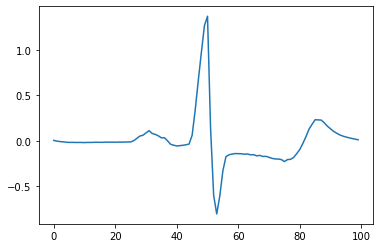

In [11]:
plt.plot(mu_xph)

In [12]:
%run ComputeSampleCovariances.ipynb
S_xph, S_sph, var_xph, var_sph = ComputeSampleCovariances(xph, var_n, B)
sd_xph = np.sqrt(var_xph)

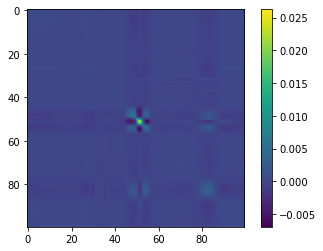

In [13]:
plt.imshow(S_sph[0:100,0:100])
plt.colorbar()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


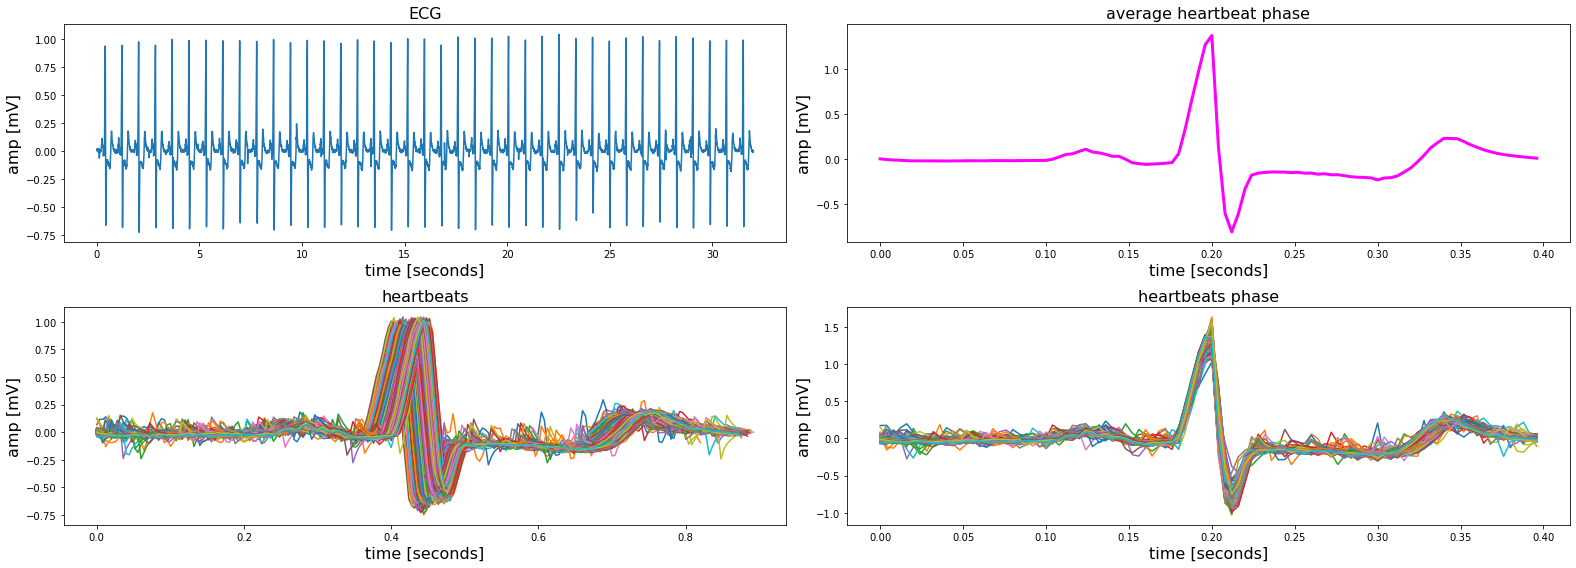

In [14]:
%run PlotTransitionECG.ipynb
target_file = '../Figs/pISCE_GP_TransFS2'
PlotTransitionECG(x, xph, mu_xph, var_xph, fs, target_file)

In [15]:
%run ComputeSampleCovariances.ipynb
Sxph, Ssph, varxph, varsph = ComputeSampleCovariances(xph, var_n, B)
invSxph = np.linalg.inv(Sxph) 
SxphinvSxph = np.matmul(Sxph,invSxph)

In [40]:
%run ComputeECGmean.ipynb
#Theta = ThetaF
mu_s = ComputeECGmean(Theta, invB, mu_xph)
diff = np.array(x_n_f) - np.array(mu_s)
Rho = 1/var_n * np.linalg.inv(Ssph) 
#M = invB - np.linalg.inv(len(x) * Rho + B)
M = invB - np.linalg.inv(Rho + B)
#D = 
s_h = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
s_h1 = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, np.array(x_n_f))))
#s_hCC = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(D, np.matmul(Theta, diff)))

In [41]:
%run ComputeInputOutputDeltaSNRs.ipynb
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h1))
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h))
print(ComputeInputOutputDeltaSNRs(x_f, n, mu_s))

(24.98277214162039, 12.202929849572941, -12.77984229204745)
(24.98277214162039, 16.112931315331178, -8.869840826289213)
(24.98277214162039, 14.312320957904547, -10.670451183715844)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


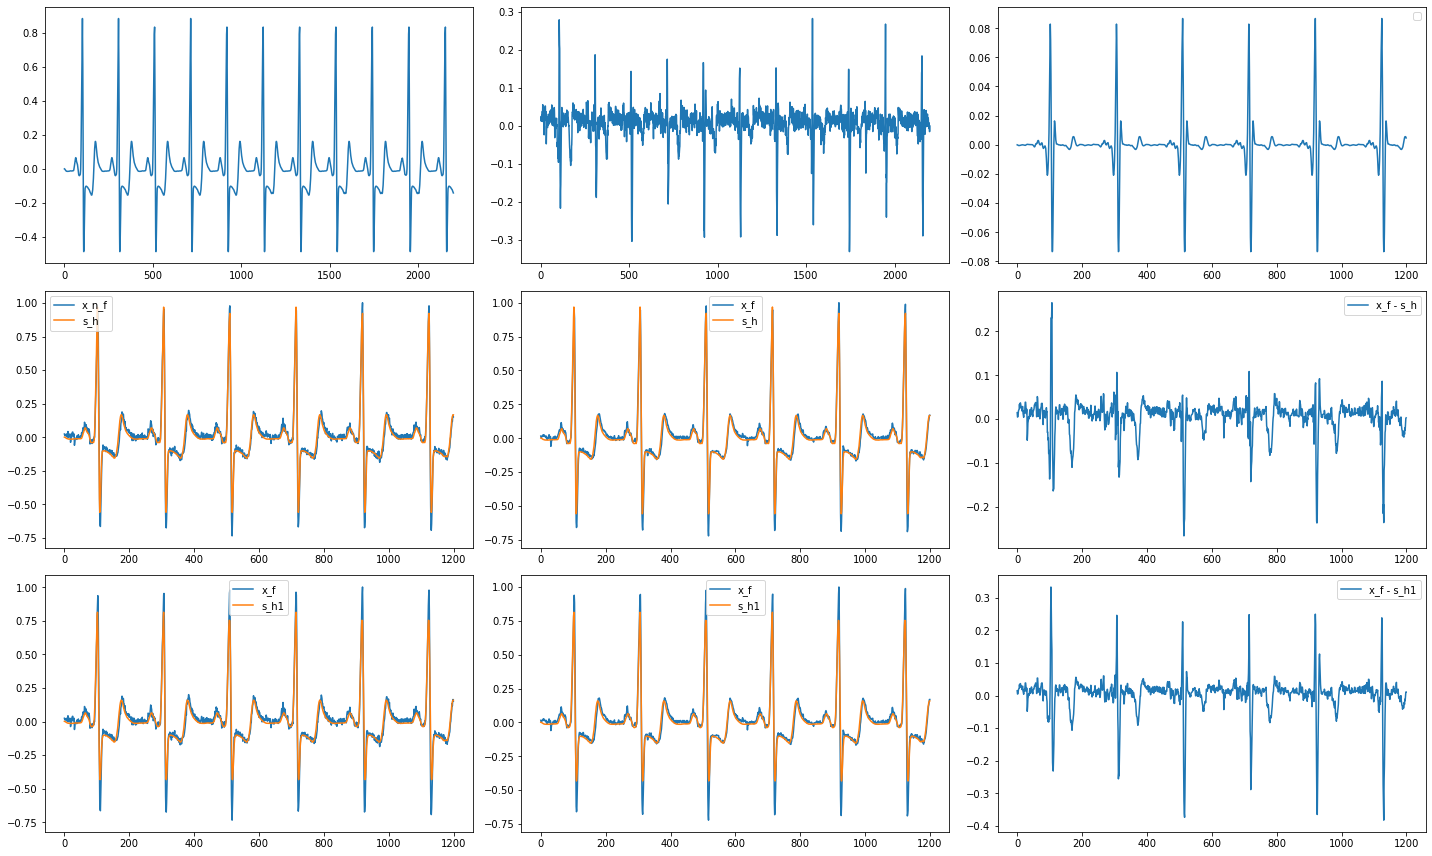

In [42]:
ttt = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
fig = plt.figure(figsize = (20,12))    
#-----------------------
plt.subplot(3,3,1)
plt.plot(mu_s[0:2200])
#-----
plt.subplot(3,3,2)
plt.plot(diff[0:2200])
#-----
plt.subplot(3,3,3)
plt.plot(ttt[0:1200])
plt.legend()
#-----------------------
plt.subplot(3,3,4)
plt.plot(x_n_f[0:1200], label  = 'x_n_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
plt.subplot(3,3,5)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
diff = x_f - s_h
plt.subplot(3,3,6)
plt.plot(diff[0:1200], label  = 'x_f - s_h')
plt.legend()
#-----------------------
plt.subplot(3,3,7)
plt.plot(x_n_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
plt.subplot(3,3,8)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
diff = x_f - s_h1
plt.subplot(3,3,9)
plt.plot(diff[0:1200], label  = 'x_f - s_h1')
plt.legend()
#-----------------------
fig.tight_layout()

In [ ]:
plt.imshow()

In [37]:
%run ComputeECGmean.ipynb
Theta = ThetaF
mu_s = ComputeECGmean(Theta, invB, mu_xph)
diff = np.array(x_n_f) - np.array(mu_s)
Rho = 1/var_n * np.linalg.inv(Ssph) 
M = invB - np.linalg.inv(len(x) * Rho + B)
#D = 
s_h = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
s_h1 = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, np.array(x_n_f))))
#s_hCC = np.array(mu_s) + 1/len(x) * np.matmul(Theta.T, np.matmul(D, np.matmul(Theta, diff)))

In [38]:
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h1))
print(ComputeInputOutputDeltaSNRs(x_f, n, s_h))
print(ComputeInputOutputDeltaSNRs(x_f, n, mu_s))

(24.98277214162039, 12.202946648028544, -12.779825493591847)
(24.98277214162039, 16.11293271423205, -8.869839427388342)
(24.98277214162039, 14.312320957904547, -10.670451183715844)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


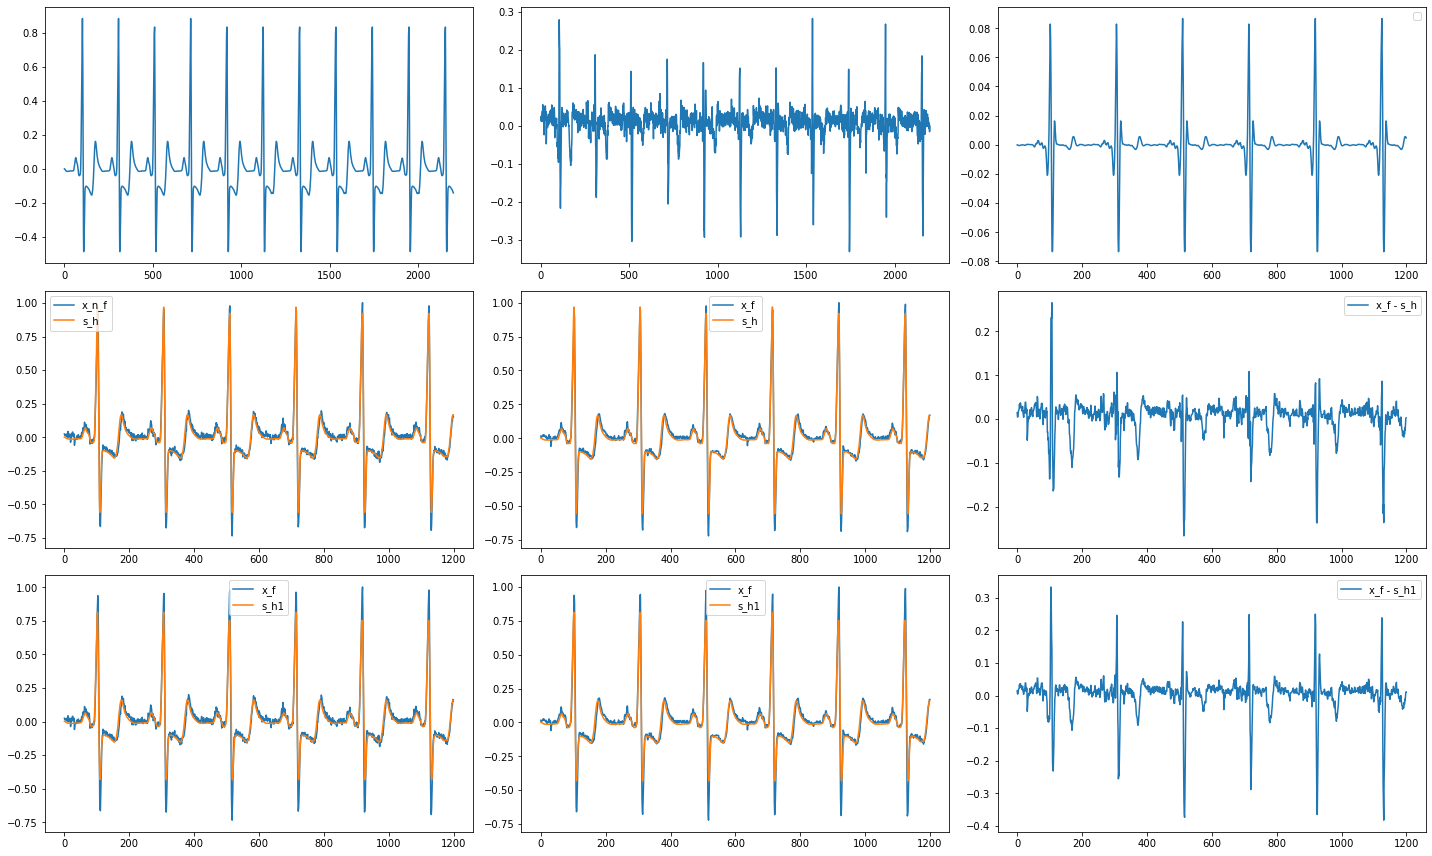

In [39]:
ttt = 1/len(x) * np.matmul(Theta.T, np.matmul(M, np.matmul(Theta, diff)))
fig = plt.figure(figsize = (20,12))    
#-----------------------
plt.subplot(3,3,1)
plt.plot(mu_s[0:2200])
#-----
plt.subplot(3,3,2)
plt.plot(diff[0:2200])
#-----
plt.subplot(3,3,3)
plt.plot(ttt[0:1200])
plt.legend()
#-----------------------
plt.subplot(3,3,4)
plt.plot(x_n_f[0:1200], label  = 'x_n_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
plt.subplot(3,3,5)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h[0:1200], label  = 's_h')
plt.legend()
#-----
diff = x_f - s_h
plt.subplot(3,3,6)
plt.plot(diff[0:1200], label  = 'x_f - s_h')
plt.legend()
#-----------------------
plt.subplot(3,3,7)
plt.plot(x_n_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
plt.subplot(3,3,8)
plt.plot(x_f[0:1200], label  = 'x_f')
plt.plot(s_h1[0:1200], label  = 's_h1')
plt.legend()
#-----
diff = x_f - s_h1
plt.subplot(3,3,9)
plt.plot(diff[0:1200], label  = 'x_f - s_h1')
plt.legend()
#-----------------------
fig.tight_layout()

In [ ]:
Th[0]